# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, auc, precision_recall_curve, average_precision_score, 
                             accuracy_score)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, cross_val_score, 
                                     train_test_split)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')


# Outliers

In [2]:
data = pd.read_excel("/kaggle/input/data-cred/data1.xlsx")
data.fillna(0, inplace = True)
data['APPLICATION_DATE'] = pd.to_datetime(data['APPLICATION_DATE'])
data['AGREEMENT_DATE'] = pd.to_datetime(data['AGREEMENT_DATE'])
data['UTILIZATION_DATE'] = pd.to_datetime(data['UTILIZATION_DATE'])
data['DIFFERENCE_AA'] = (data['AGREEMENT_DATE'] - data['APPLICATION_DATE']).dt.days
data['DIFFERENCE_AU'] = (data['UTILIZATION_DATE'] - data['AGREEMENT_DATE']).dt.days
data

,APPLICATION_DATE,AGREEMENT_DATE,UTILIZATION_DATE,CNT,DIFFERENCE_AA,DIFFERENCE_AU
0,2023-04-03,2023-04-04,2023-04-04,2,1,0
1,2023-04-03,2023-04-04,2023-04-10,1,1,6
2,2023-04-03,2023-04-05,2023-04-07,1,2,2
3,2023-04-03,2023-04-06,2023-04-06,1,3,0
4,2023-04-03,2023-04-11,2023-04-15,1,8,4
...,...,...,...,...,...,...
3312,2023-06-14,2023-06-15,1970-01-01,107,1,-19523
3313,2023-06-14,1970-01-01,1970-01-01,319,-19522,0
3314,2023-06-15,2023-06-15,2023-06-15,11,0,0
3315,2023-06-15,2023-06-15,1970-01-01,37,0,-19523


In [3]:
#  Function to identify outliers based on IQR
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound


lower_bound_AA, upper_bound_AA = find_outliers(data, 'DIFFERENCE_AA')
data['outlier_AA'] = (data['DIFFERENCE_AA'] < lower_bound_AA) | (data['DIFFERENCE_AA'] > upper_bound_AA)

lower_bound_AU, upper_bound_AU = find_outliers(data, 'DIFFERENCE_AU')
data['outlier_AU'] = (data['DIFFERENCE_AU'] < lower_bound_AU) | (data['DIFFERENCE_AU'] > upper_bound_AU)

print(f"Outliers in DIFFERENCE_AA: {len(data[data['outlier_AA']])}")
print(f"Outliers in DIFFERENCE_AU: {len(data[data['outlier_AU']])}")


Outliers in DIFFERENCE_AA: 300
Outliers in DIFFERENCE_AU: 689


In [4]:
fig_AA = px.box(data , y='DIFFERENCE_AA', title='Box Plot of Difference AA',
                labels={'DIFFERENCE_AA': 'Difference AA (Days)'})

fig_AA.update_traces(marker=dict(size=8, color='red', line=dict(width=1, color='DarkSlateGrey')))

fig_AA.show()

fig_AU = px.box(data, y='DIFFERENCE_AU', title='Box Plot of Difference AU',
                labels={'DIFFERENCE_AU': 'Difference AU (Days)'})

fig_AU.update_traces(marker=dict(size=8, color='red', line=dict(width=1, color='DarkSlateGrey')))

fig_AU.show()

In [5]:
data_cleaned_AA = data[data['DIFFERENCE_AA'] >= 0]

data_cleaned_AU = data_cleaned_AA[data_cleaned_AA['DIFFERENCE_AU'] >= 0]

print("Number of rows after removing outliers in DIFFERENCE_AA and DIFFERENCE_AU:", data_cleaned_AU.shape[0])

fig_AA = px.box(data_cleaned_AU , y='DIFFERENCE_AA', title='Box Plot of Difference AA',
                labels={'DIFFERENCE_AA': 'Difference AA (Days)'})

fig_AA.update_traces(marker=dict(size=8, color='red', line=dict(width=1, color='DarkSlateGrey')))

fig_AA.show()


fig_AU = px.box(data_cleaned_AU, y='DIFFERENCE_AU', title='Box Plot of Difference AU',
                labels={'DIFFERENCE_AU': 'Difference AU (Days)'})

fig_AU.update_traces(marker=dict(size=8, color='red', line=dict(width=1, color='DarkSlateGrey')))

fig_AU.show()


Number of rows after removing outliers in DIFFERENCE_AA and DIFFERENCE_AU: 2799


In [6]:
# Filter rows 
data_filtered = data[(data['DIFFERENCE_AA'] >= 0) & (data['DIFFERENCE_AA'] <= 45) &
                     (data['DIFFERENCE_AU'] >= 0) & (data['DIFFERENCE_AU'] <= 41)]

print("Number of rows after filtering:", data_filtered.shape[0])

fig_AA_filtered = px.box(data_filtered, y='DIFFERENCE_AA', title='Box Plot of Filtered Difference AA',
                        labels={'DIFFERENCE_AA': 'Difference AA (Days)'})

fig_AA_filtered.update_traces(marker=dict(size=8,color='red', line=dict(width=1, color='DarkSlateGrey')))
fig_AA_filtered.show()

fig_AU_filtered = px.box(data_filtered, y='DIFFERENCE_AU', title='Box Plot of Filtered Difference AU',
                        labels={'DIFFERENCE_AU': 'Difference AU (Days)'})

fig_AU_filtered.update_traces(marker=dict(size=8, color='red', line=dict(width=1, color='DarkSlateGrey')))
fig_AU_filtered.show()


Number of rows after filtering: 2791


In [7]:
data_filtered.drop(columns =["outlier_AA","outlier_AU"], inplace = True )

In [8]:
data = data_filtered.copy()
data

,APPLICATION_DATE,AGREEMENT_DATE,UTILIZATION_DATE,CNT,DIFFERENCE_AA,DIFFERENCE_AU
0,2023-04-03,2023-04-04,2023-04-04,2,1,0
1,2023-04-03,2023-04-04,2023-04-10,1,1,6
2,2023-04-03,2023-04-05,2023-04-07,1,2,2
3,2023-04-03,2023-04-06,2023-04-06,1,3,0
4,2023-04-03,2023-04-11,2023-04-15,1,8,4
...,...,...,...,...,...,...
3305,2023-06-13,2023-06-15,2023-06-15,14,2,0
3308,2023-06-14,2023-06-14,2023-06-14,20,0,0
3309,2023-06-14,2023-06-14,2023-06-15,12,0,1
3311,2023-06-14,2023-06-15,2023-06-15,63,1,0


In [9]:
import pandas as pd
import plotly.express as px

# Convert 'UTILIZATION_DATE' to datetime if not already
data['UTILIZATION_DATE'] = pd.to_datetime(data['UTILIZATION_DATE'])

# Set 'UTILIZATION_DATE' as the index for resampling
data.set_index('UTILIZATION_DATE', inplace=True)

# Aggregate by day
daily_agg = data.resample('D').agg({
    'CNT': 'sum',
    'DIFFERENCE_AA': 'mean',
    'DIFFERENCE_AU': 'mean'
}).reset_index()

# Resample weekly and aggregate
weekly_agg = data.resample('W').agg({
    'CNT': 'sum',
    'DIFFERENCE_AA': 'mean',
    'DIFFERENCE_AU': 'mean'
}).reset_index()

# Resample monthly and aggregate
monthly_agg = data.resample('M').agg({
    'CNT': 'sum',
    'DIFFERENCE_AA': 'mean',
    'DIFFERENCE_AU': 'mean'
}).reset_index()

# Plot daily aggregations
fig_daily = px.line(daily_agg, x='UTILIZATION_DATE', y='CNT', title='Daily Utilizations',
                    labels={'UTILIZATION_DATE': 'Date', 'CNT': 'Count'})
fig_daily.update_traces(line=dict(color='red'))
fig_daily.show()

# Plot weekly aggregations
fig_weekly = px.line(weekly_agg, x='UTILIZATION_DATE', y='CNT', title='Weekly Utilizations',
                     labels={'UTILIZATION_DATE': 'Date', 'CNT': 'Count'})
fig_weekly.update_traces(line=dict(color='red'))
fig_weekly.show()

# Plot monthly aggregations
fig_monthly = px.line(monthly_agg, x='UTILIZATION_DATE', y='CNT', title='Monthly Utilizations',
                      labels={'UTILIZATION_DATE': 'Date', 'CNT': 'Count'})
fig_monthly.update_traces(line=dict(color='red'))
fig_monthly.show()


In [10]:
data = data.reset_index()
data

,UTILIZATION_DATE,APPLICATION_DATE,AGREEMENT_DATE,CNT,DIFFERENCE_AA,DIFFERENCE_AU
0,2023-04-04,2023-04-03,2023-04-04,2,1,0
1,2023-04-10,2023-04-03,2023-04-04,1,1,6
2,2023-04-07,2023-04-03,2023-04-05,1,2,2
3,2023-04-06,2023-04-03,2023-04-06,1,3,0
4,2023-04-15,2023-04-03,2023-04-11,1,8,4
...,...,...,...,...,...,...
2786,2023-06-15,2023-06-13,2023-06-15,14,2,0
2787,2023-06-14,2023-06-14,2023-06-14,20,0,0
2788,2023-06-15,2023-06-14,2023-06-14,12,0,1
2789,2023-06-15,2023-06-14,2023-06-15,63,1,0


# Prophet

In [11]:
# Aggregate data
daily_agg = data.groupby('UTILIZATION_DATE').agg({'CNT': 'sum'}).reset_index()
daily_agg.rename(columns={'UTILIZATION_DATE': 'ds', 'CNT': 'y'}, inplace=True)

model = Prophet()
model.add_regressor('lag_1')
model.add_regressor('lag_7')

#lag features for training data
daily_agg['lag_1'] = daily_agg['y'].shift(1).fillna(0)
daily_agg['lag_7'] = daily_agg['y'].shift(7).fillna(0)
model.fit(daily_agg)

# future dates DataFrame for predictions
future_dates = model.make_future_dataframe(periods=46)  # Forecast till 31st July 2023
future_dates['day_of_week'] = future_dates['ds'].dt.dayofweek
future_dates['month'] = future_dates['ds'].dt.month

# For future dates beyond the original data, set lag_1 and lag_7 to zero 
future_dates['lag_1'] = daily_agg['y'].shift(1).reindex(future_dates.index).fillna(0)
future_dates['lag_7'] = daily_agg['y'].shift(7).reindex(future_dates.index).fillna(0)

# Fill NaNs for future dates with 0
future_dates['lag_1'].fillna(0, inplace=True)
future_dates['lag_7'].fillna(0, inplace=True)
forecast = model.predict(future_dates)

#daily visualization
fig = px.line(daily_agg, x='ds', y='y', title='Daily Utilizations', labels={'ds': 'Date', 'y': 'Number of Utilizations'})
fig.add_scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines', name='Forecast')
fig.add_scatter(x=forecast['ds'], y=forecast['yhat_lower'], mode='lines', name='Lower Confidence Interval', line=dict(dash='dash'))
fig.add_scatter(x=forecast['ds'], y=forecast['yhat_upper'], mode='lines', name='Upper Confidence Interval', line=dict(dash='dash'))
fig.update_layout(title='Daily Utilizations Forecast with Prophet')
fig.show()

# monthly visualization
monthly_agg = data.groupby(data['UTILIZATION_DATE'].dt.to_period('M')).agg({'CNT': 'sum'}).reset_index()
monthly_agg['UTILIZATION_DATE'] = monthly_agg['UTILIZATION_DATE'].dt.to_timestamp()

# Monthly forecast plotting
fig_monthly = px.line(monthly_agg, x='UTILIZATION_DATE', y='CNT', title='Monthly Utilizations',
                      labels={'UTILIZATION_DATE': 'Date', 'CNT': 'Count'})
fig_monthly.show()

14:16:12 - cmdstanpy - INFO - Chain [1] start processing
14:16:12 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Aggregate data by day
daily_agg = data.groupby('UTILIZATION_DATE').agg({'CNT': 'sum'}).reset_index()
daily_agg.rename(columns={'UTILIZATION_DATE': 'ds', 'CNT': 'y'}, inplace=True)

#additional features
daily_agg['lag_1'] = daily_agg['y'].shift(1).fillna(0)
daily_agg['lag_7'] = daily_agg['y'].shift(7).fillna(0)
daily_agg['day_of_week'] = daily_agg['ds'].dt.dayofweek
daily_agg['month'] = daily_agg['ds'].dt.month

#  model
model = Prophet()
model.add_regressor('lag_1')
model.add_regressor('lag_7')
model.add_regressor('day_of_week')
model.add_regressor('month')
model.fit(daily_agg)

#  future dates DataFrame for predictions
future_dates = model.make_future_dataframe(periods=46)  # Forecast till 31st July 2023

# Create features for future dates
future_dates['lag_1'] = daily_agg['y'].shift(1).reindex(future_dates.index).fillna(0)
future_dates['lag_7'] = daily_agg['y'].shift(7).reindex(future_dates.index).fillna(0)
future_dates['day_of_week'] = future_dates['ds'].dt.dayofweek
future_dates['month'] = future_dates['ds'].dt.month

#  NaNs for future dates
future_dates['lag_1'].fillna(0, inplace=True)
future_dates['lag_7'].fillna(0, inplace=True)

#  predictions
forecast = model.predict(future_dates)


# Daily Utilizations with Additional Features
fig_daily = px.line(daily_agg, x='ds', y='y', title='Daily Utilizations with Additional Features',
                    labels={'ds': 'Date', 'y': 'Number of Utilizations'})
fig_daily.add_scatter(x=daily_agg['ds'], y=daily_agg['lag_1'], mode='lines', name='Lag 1', line=dict(color='orange'))
fig_daily.add_scatter(x=daily_agg['ds'], y=daily_agg['lag_7'], mode='lines', name='Lag 7', line=dict(color='green'))
fig_daily.update_layout(title='Daily Utilizations with Lag Features')
fig_daily.show()

#Weekly Aggregated Utilizations
daily_agg['week'] = daily_agg['ds'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_agg = daily_agg.groupby('week').agg({'y': 'sum'}).reset_index()
weekly_agg.rename(columns={'week': 'ds'}, inplace=True)

fig_weekly = px.line(weekly_agg, x='ds', y='y', title='Weekly Aggregated Utilizations',
                     labels={'ds': 'Date', 'y': 'Number of Utilizations'})
fig_weekly.show()

# Monthly Aggregated Utilizations
monthly_agg = daily_agg.groupby(daily_agg['ds'].dt.to_period('M')).agg({'y': 'sum'}).reset_index()
monthly_agg['ds'] = monthly_agg['ds'].dt.to_timestamp()

fig_monthly = px.line(monthly_agg, x='ds', y='y', title='Monthly Aggregated Utilizations',
                      labels={'ds': 'Date', 'y': 'Number of Utilizations'})
fig_monthly.show()

# Feature Correlations
fig_corr = px.imshow(daily_agg[['y', 'lag_1', 'lag_7', 'day_of_week', 'month']].corr(), 
                     title="Feature Correlations", 
                     labels={'color': 'Correlation'})
fig_corr.show()



14:16:13 - cmdstanpy - INFO - Chain [1] start processing
14:16:13 - cmdstanpy - INFO - Chain [1] done processing


# SARIMAMAX

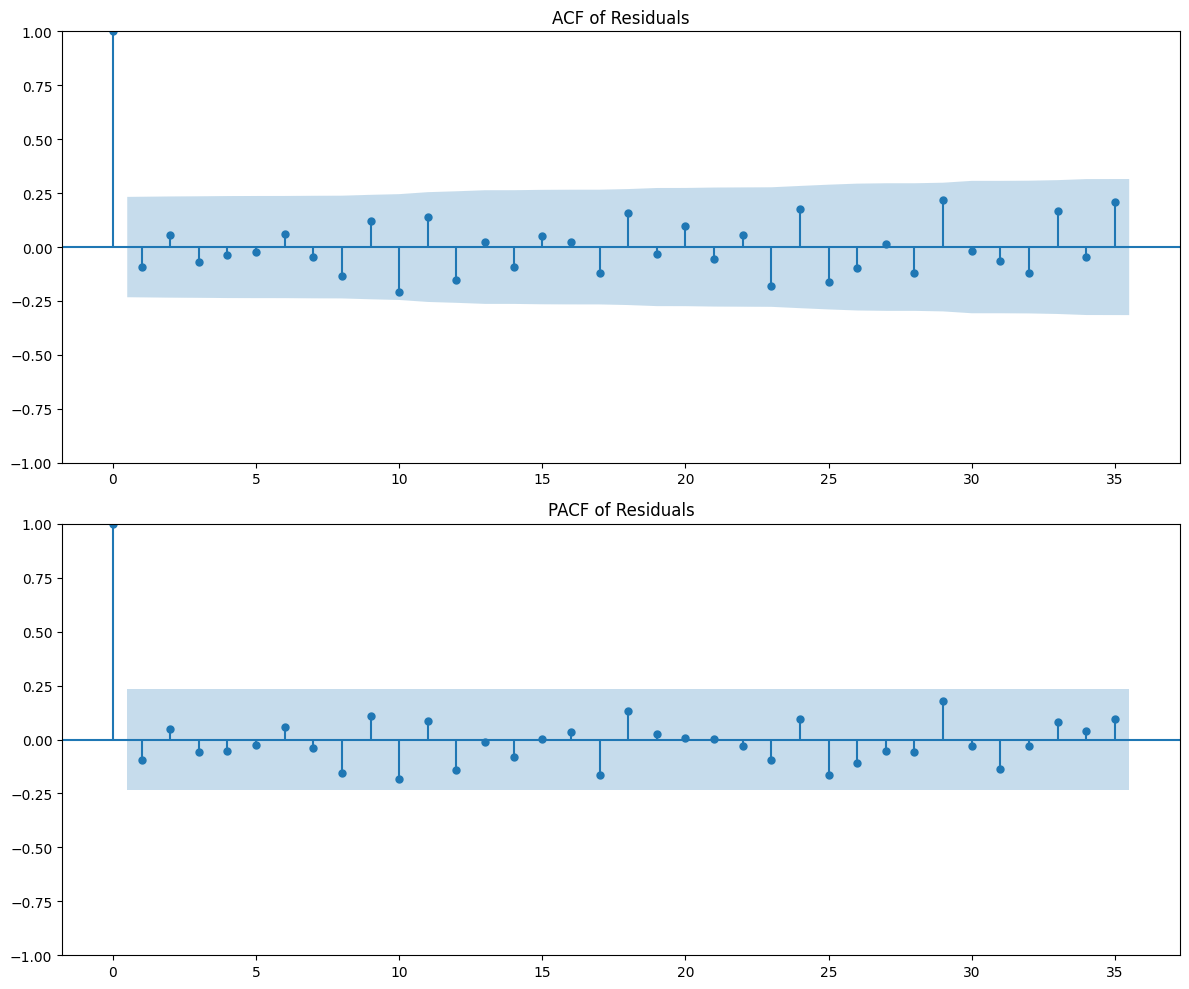

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(daily_agg['y'],
                       order=(1, 1, 1),  # Non-seasonal orders
                       seasonal_order=(1, 1, 1, 7),  # Seasonal orders
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)
residuals = sarima_fit.resid

# the maximum number of lags based on the sample size
max_lags = min(len(residuals) // 2, 50)

# ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

plot_acf(residuals, ax=ax[0], lags=max_lags)
ax[0].set_title('ACF of Residuals')

plot_pacf(residuals, ax=ax[1], lags=max_lags)
ax[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()


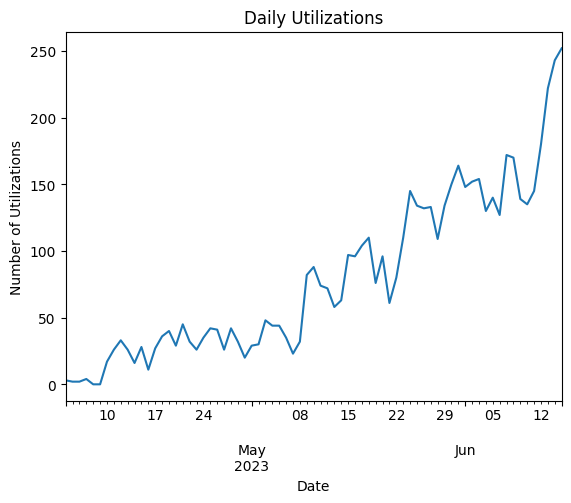

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   73
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -233.599
Date:                           Mon, 12 Aug 2024   AIC                            477.199
Time:                                   14:16:16   BIC                            487.326
Sample:                               04-04-2023   HQIC                           481.125
                                    - 06-15-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3283      0.621     -0.529      0.597      -1.545       0.888
ma.L1          0.1021      0.622      0.164

In [14]:
daily_agg = data.groupby('UTILIZATION_DATE').agg({'CNT': 'sum'}).reset_index()
daily_agg.rename(columns={'UTILIZATION_DATE': 'ds', 'CNT': 'y'}, inplace=True)

# 'ds' as the index
daily_agg.set_index('ds', inplace=True)
daily_agg = daily_agg.asfreq('D')  
daily_agg['y'].fillna(0, inplace=True)  #  NaNs with 0s

# Plot the data
daily_agg['y'].plot(title='Daily Utilizations')
plt.xlabel('Date')
plt.ylabel('Number of Utilizations')
plt.show()

# the SARIMA model
sarima_model = SARIMAX(daily_agg['y'],
                       order=(1, 1, 1),  # (p, d, q) - Non-seasonal orders
                       seasonal_order=(1, 1, 1, 7),  # (P, D, Q, s) - Seasonal orders, with weekly seasonality
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())

# Forecast future dates
forecast_periods = 70  
forecast = sarima_fit.get_forecast(steps=forecast_periods)
forecast_index = pd.date_range(start=daily_agg.index[-1] + pd.Timedelta(days=1), periods=forecast_periods, freq='D')

# Extract forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# forecast index to a Series for plotting
forecast_index_series = pd.Series(forecast_index)

fig = go.Figure()

# historical data
fig.add_trace(go.Scatter(x=daily_agg.index, y=daily_agg['y'], mode='lines', name='Historical Data'))

# forecast data
fig.add_trace(go.Scatter(x=forecast_index_series, y=forecast_mean, mode='lines', name='Forecast'))

#confidence intervals
fig.add_trace(go.Scatter(
    x=pd.concat([forecast_index_series, forecast_index_series[::-1]]),
    y=pd.concat([forecast_ci['lower y'], forecast_ci['upper y'][::-1]]),
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Confidence Interval'
))

fig.update_layout(title='Utilizations Forecast with SARIMA',
                  xaxis_title='Date',
                  yaxis_title='Number of Utilizations',
                  legend_title='Legend')
fig.show()

# Calculate cumulative utilization
daily_agg['cumulative_y'] = daily_agg['y'].cumsum()
forecast_cumulative_mean = forecast_mean.cumsum()
forecast_cumulative_ci_lower = forecast_ci['lower y'].cumsum()
forecast_cumulative_ci_upper = forecast_ci['upper y'].cumsum()

# Plotting the forecast
fig = go.Figure()

# Add historical data
fig.add_trace(go.Scatter(x=daily_agg.index, y=daily_agg['cumulative_y'], mode='lines', name='Historical Cumulative Data'))

# Add forecast data
fig.add_trace(go.Scatter(x=forecast_index_series, y=forecast_cumulative_mean, mode='lines', name='Forecast Cumulative'))

# Add confidence intervals
fig.add_trace(go.Scatter(
    x=pd.concat([forecast_index_series, forecast_index_series[::-1]]),
    y=pd.concat([forecast_cumulative_ci_lower, forecast_cumulative_ci_upper[::-1]]),
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Confidence Interval'
))

fig.update_layout(title='Cumulative Utilizations Forecast with SARIMA',
                  xaxis_title='Date',
                  yaxis_title='Cumulative Number of Utilizations',
                  legend_title='Legend')
fig.show()

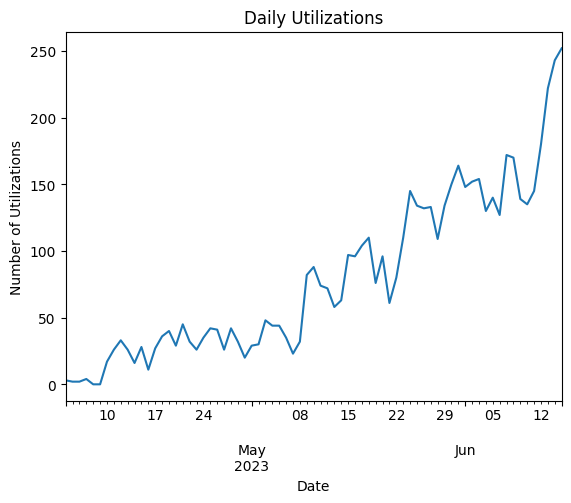

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   73
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -233.599
Date:                           Mon, 12 Aug 2024   AIC                            477.199
Time:                                   14:16:17   BIC                            487.326
Sample:                               04-04-2023   HQIC                           481.125
                                    - 06-15-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3283      0.621     -0.529      0.597      -1.545       0.888
ma.L1          0.1021      0.622      0.164

Avg_Mean Squared Error: 73348.49267305134
Avg_Mean Absolute Error: 22.755289962385163


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

daily_agg = data.groupby('UTILIZATION_DATE').agg({'CNT': 'sum'}).reset_index()
daily_agg.rename(columns={'UTILIZATION_DATE': 'ds', 'CNT': 'y'}, inplace=True)

# Set 'ds' as the index
daily_agg.set_index('ds', inplace=True)
daily_agg = daily_agg.asfreq('D')  # Ensure the data is daily frequency
daily_agg['y'].fillna(0, inplace=True)  # Fill NaNs with 0s

# Plot the daily data
daily_agg['y'].plot(title='Daily Utilizations')
plt.xlabel('Date')
plt.ylabel('Number of Utilizations')
plt.show()

# SARIMA model
sarima_model = SARIMAX(daily_agg['y'],
                       order=(1, 1, 1),  # (p, d, q) - Non-seasonal orders
                       seasonal_order=(1, 1, 1, 7),  # (P, D, Q, s) - Seasonal orders, with weekly seasonality
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_fit = sarima_model.fit(disp=False)
print(sarima_fit.summary())

# Forecast future dates
forecast_periods = 70
forecast = sarima_fit.get_forecast(steps=forecast_periods)
forecast_index = pd.date_range(start=daily_agg.index[-1] + pd.Timedelta(days=1), periods=forecast_periods, freq='D')

#  forecast mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# forecast index to a Series for plotting
forecast_index_series = pd.Series(forecast_index)

# the forecast
fig = go.Figure()

# historical data
fig.add_trace(go.Scatter(x=daily_agg.index, y=daily_agg['y'], mode='lines', name='Historical Data'))

# forecast data
fig.add_trace(go.Scatter(x=forecast_index_series, y=forecast_mean, mode='lines', name='Forecast'))

# confidence intervals
fig.add_trace(go.Scatter(
    x=pd.concat([forecast_index_series, forecast_index_series[::-1]]),
    y=pd.concat([forecast_ci['lower y'], forecast_ci['upper y'][::-1]]),
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Confidence Interval'
))

fig.update_layout(title='Utilizations Forecast with SARIMA',
                  xaxis_title='Date',
                  yaxis_title='Number of Utilizations',
                  legend_title='Legend')
fig.show()

# cumulative utilization
daily_agg['cumulative_y'] = daily_agg['y'].cumsum()
forecast_cumulative_mean = forecast_mean.cumsum()
forecast_cumulative_ci_lower = forecast_ci['lower y'].cumsum()
forecast_cumulative_ci_upper = forecast_ci['upper y'].cumsum()

#cumulative forecast
fig = go.Figure()

# historical cumulative data
fig.add_trace(go.Scatter(x=daily_agg.index, y=daily_agg['cumulative_y'], mode='lines', name='Historical Cumulative Data'))

# forecast cumulative data
fig.add_trace(go.Scatter(x=forecast_index_series, y=forecast_cumulative_mean, mode='lines', name='Forecast Cumulative'))

# confidence intervals
fig.add_trace(go.Scatter(
    x=pd.concat([forecast_index_series, forecast_index_series[::-1]]),
    y=pd.concat([forecast_cumulative_ci_lower, forecast_cumulative_ci_upper[::-1]]),
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Confidence Interval'
))

fig.update_layout(title='Cumulative Utilizations Forecast with SARIMA',
                  xaxis_title='Date',
                  yaxis_title='Cumulative Number of Utilizations',
                  legend_title='Legend')
fig.show()

# Model evaluation
start_date = daily_agg.index[0]
end_date = daily_agg.index[-1]

historical_forecast = sarima_fit.get_prediction(start=start_date, end=end_date)
historical_forecast_mean = historical_forecast.predicted_mean
historical_forecast_ci = historical_forecast.conf_int()

# Calculate performance metrics
mse = mean_squared_error(daily_agg['cumulative_y'].loc[start_date:end_date], historical_forecast_mean)/len(daily_agg)
mae = mean_absolute_error(daily_agg['cumulative_y'].loc[start_date:end_date], historical_forecast_mean)/len(daily_agg)

print(f'Avg_Mean Squared Error: {mse}')
print(f'Avg_Mean Absolute Error: {mae}')


In [16]:
daily_agg = data.groupby('UTILIZATION_DATE').agg({'CNT': 'sum'}).reset_index()
daily_agg.rename(columns={'UTILIZATION_DATE': 'ds', 'CNT': 'y'}, inplace=True)

daily_agg.set_index('ds', inplace=True)
daily_agg = daily_agg.asfreq('D')  
daily_agg['y'].fillna(0, inplace=True)  
daily_agg['cumulative_y'] = daily_agg['y'].cumsum()

# training, validation, and test sets
train_size = int(len(daily_agg) * 0.7)
valid_size = int(len(daily_agg) * 0.2)

train = daily_agg[:train_size]
valid = daily_agg[train_size:train_size+valid_size]
test = daily_agg[train_size+valid_size:]
train = train.reset_index()
valid = valid.reset_index()
test = test.reset_index()
model_daily = Prophet()
model_daily.fit(train[['ds', 'y']])

future_daily = model_daily.make_future_dataframe(periods=len(valid), freq='D')
forecast_daily = model_daily.predict(future_daily)

valid_forecast_daily = forecast_daily[forecast_daily['ds'].isin(valid['ds'])]
mae_daily = mean_absolute_error(valid['y'], valid_forecast_daily['yhat'][:len(valid)])
mse_daily = mean_squared_error(valid['y'], valid_forecast_daily['yhat'][:len(valid)])
print(f'Daily Utilizations - MAE: {mae_daily}, MSE: {mse_daily}')

model_cumulative = Prophet()
train_cumulative = train[['ds', 'cumulative_y']].rename(columns={'cumulative_y': 'y'})
model_cumulative.fit(train_cumulative)

# future dataframe and  predictions for validation
future_cumulative = model_cumulative.make_future_dataframe(periods=len(valid), freq='D')
forecast_cumulative = model_cumulative.predict(future_cumulative)

# the model on validation set
valid_cumulative_forecast = forecast_cumulative[forecast_cumulative['ds'].isin(valid['ds'])]
mae_cumulative = mean_absolute_error(valid['cumulative_y'], valid_cumulative_forecast['yhat'][:len(valid)])
mse_cumulative = mean_squared_error(valid['cumulative_y'], valid_cumulative_forecast['yhat'][:len(valid)])
print(f'Cumulative Utilizations - MAE: {mae_cumulative}, MSE: {mse_cumulative}')

forecast_periods = 70
future_daily_full = model_daily.make_future_dataframe(periods=forecast_periods, freq='D')
forecast_daily_full = model_daily.predict(future_daily_full)

# Cumulative Utilization Forecast
future_cumulative_full = model_cumulative.make_future_dataframe(periods=forecast_periods, freq='D')
forecast_cumulative_full = model_cumulative.predict(future_cumulative_full)

fig_daily = go.Figure()


fig_daily.add_trace(go.Scatter(x=daily_agg.index, y=daily_agg['y'], mode='lines', name='Historical Daily Utilizations'))

# Add daily forecast data
fig_daily.add_trace(go.Scatter(x=forecast_daily_full['ds'], y=forecast_daily_full['yhat'], mode='lines', name='Forecast Daily Utilizations'))

# Add daily confidence intervals
fig_daily.add_trace(go.Scatter(
    x=pd.concat([forecast_daily_full['ds'], forecast_daily_full['ds'][::-1]]),
    y=pd.concat([forecast_daily_full['yhat_lower'], forecast_daily_full['yhat_upper'][::-1]]),
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Confidence Interval (Daily)'
))

fig_daily.update_layout(title='Daily Utilizations Forecast with Prophet',
                        xaxis_title='Date',
                        yaxis_title='Number of Utilizations',
                        legend_title='Legend')
fig_daily.show()

# Plotting Cumulative Utilizations Forecast
fig_cumulative = go.Figure()

#  historical cumulative data
fig_cumulative.add_trace(go.Scatter(x=daily_agg.index, y=daily_agg['cumulative_y'], mode='lines', name='Historical Cumulative Utilizations'))

#  cumulative forecast data
fig_cumulative.add_trace(go.Scatter(x=forecast_cumulative_full['ds'], y=forecast_cumulative_full['yhat'], mode='lines', name='Forecast Cumulative Utilizations'))

#  cumulative confidence intervals
fig_cumulative.add_trace(go.Scatter(
    x=pd.concat([forecast_cumulative_full['ds'], forecast_cumulative_full['ds'][::-1]]),
    y=pd.concat([forecast_cumulative_full['yhat_lower'], forecast_cumulative_full['yhat_upper'][::-1]]),
    fill='toself',
    fillcolor='rgba(100,0,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Confidence Interval (Cumulative)'
))

fig_cumulative.update_layout(title='Cumulative Utilizations Forecast with Prophet',
                             xaxis_title='Date',
                             yaxis_title='Cumulative Number of Utilizations',
                             legend_title='Legend')
fig_cumulative.show()


14:16:17 - cmdstanpy - INFO - Chain [1] start processing
14:16:17 - cmdstanpy - INFO - Chain [1] done processing
14:16:18 - cmdstanpy - INFO - Chain [1] start processing


Daily Utilizations - MAE: 32.139891881918864, MSE: 1127.633135756509


14:16:18 - cmdstanpy - INFO - Chain [1] done processing


Cumulative Utilizations - MAE: 385.7798664484071, MSE: 192842.80122723797


In [17]:
data = data.reset_index()